In [1]:
import numpy as np
import math
import copy
import time

In [2]:
#Open + read file
a = open('multidim-data.txt', 'r')
sample = a.readlines()
sample = [x.strip('\n') for x in sample] 
sample = [x.split(',') for x in sample] 

#Delete all the attributes you don't care about
for i, asdf in enumerate(sample):
    del(asdf[7])
    del(asdf[0:4])
    
#Turn strings into floats
for i in range(len(sample)):
    for j in range(len(sample[i])):
        sample[i][j] = float(sample[i][j])
        


In [3]:
#distance metric, this seems to be one of the best ones for multidimensional analysis although you can change it if you like.
def hellinger_dist(sampleDist, PDF):
    coefficient = 0
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i] / totalSum
    for i in indices:
        coefficient += math.sqrt(tempDist[i]*PDF[i])
    return math.sqrt(1-coefficient)

def euclidean_dist(sampleDist, PDF):
    dist = np.zeros([numBins for i in range(m)])
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i]/totalSum
    for i in indices:
        dist[i] += tempDist[i] - PDF[i]
    return dist

In [4]:
#Recursive helper function to give us all indices so that we can get the values correctly for the multidimensional case.
#You should use this to set a global variable before you need to use it so you only need to call this once. If you call this
#function many times with many dimensions, it will slow down your code a lot.

def nd_range(start, stop, dims):
    if not dims:
        yield ()
        return
    for outer in nd_range(start, stop, dims - 1):
        for inner in range(start, stop):
            yield outer + (inner,)

In [6]:
#This assumes that your sample is currently an array of arrays, each array corresponding to an element and its elements being the
#values of the variables as floats.

#you have to define this global variable before you can run the rest of it.
numBins = 5
    
    
def sample_to_pdf(sample, numObjects): #sample is the sample that we wish to take a subsample from and numobjects is the number
#of groupings we wish to create for the main function.
    m = len(sample[0])
    n = len(sample)
    
    #Compute extrema for binning
    maxValues = np.zeros((m,))
    for i in range(m):
        maxValues[i] = -float('inf')
    for i in sample:
        for j in range(len(i)):
            if i[j] > maxValues[j]:
                maxValues[j] = i[j]
    for i in range(m):
        maxValues[i] += 0.0001

    minValues = np.zeros((m,))
    for i in range(m):
        minValues[i] = float('inf')
    for i in sample:
        for j in range(len(i)):
            if i[j] < minValues[j]:
                minValues[j] = i[j]
    
    

    binSize = (maxValues - minValues) / numBins
    #Create the bins and bin the sample so we get our pdfs as well as the overall pdf.
    tempList = [numObjects]
    tempList.extend([numBins for i in range(m)])
    distributions = np.zeros(tempList)
    overallPDF = np.zeros([numBins for i in range(m)])
    for element in sample:
        i = np.random.randint(0,numObjects)
        
        pos = [0 for i in range(m)]
        for j in range(m):
            pos[j] = math.floor((element[j]-minValues[j]) / binSize[j])
        positions = tuple(pos)
        distributions[i][positions]+= 1
        overallPDF[positions]+=1
    weights = np.zeros((numObjects,))
    for i in range(numObjects):
        weights[i] = np.sum(distributions[i])
    overallPDF = overallPDF / np.sum(overallPDF)
    for i, split in enumerate(distributions):
        tempSum = np.sum(split)
        distributions[i] = split / tempSum
    return weights, distributions, overallPDF

In [239]:
maxWeight = 10000
sampleProportion = 1/5
significanceLevel = 0.99931
m = 3
w, p, overallPDF =sample_to_pdf(sample, 10000)
indices = list(nd_range(0, numBins, m)) #global variable corresponding to all the indices so we only need to generate them once.
#It stores everything as tuples and we just call indices to get indices for multidimensional things since nested for loops don't
#work with an unknown number of dimensions.
def multi_dim_knapsack(w, p, maxWeight):
    n = len(w)
    m = len(p.shape)-1
    totalWeight = 0
    currentPDF = np.zeros([numBins for i in range(m)])
    contents = dict()
    weight = max(w)
    #first, we take a simple random sample that has weight at most maxWeight/2. It should be similar to the population density.
    while True:
        i = np.random.randint(0,n)
        if i not in contents:
            if totalWeight + w[i] > maxWeight*sampleProportion:
                break
            else:
                contents[i] = 1
                totalWeight += w[i]
                for k in indices:
                    currentPDF[k] += w[i]*p[i][k]
    #Now, we add objects to this sample to try to correct it and make it closer to the population density
    
    
    #This is the approach that adds 1 object at a time. This time, we just take anything that's significantly better
    currentDeviation = hellinger_dist(currentPDF, overallPDF)
    pairAdded = True
    numIts=0
    while pairAdded:
        counter = 0
        for i, weight in enumerate(w):
            if i not in contents and totalWeight+w[i] <= maxWeight:
                tempPDF = copy.deepcopy(currentPDF)
                for k in indices:
                    tempPDF[k] += w[i]*p[i][k]
                tempDeviation = hellinger_dist(tempPDF, overallPDF)
                if tempDeviation <= (significanceLevel)*currentDeviation:
                    currentDeviation = tempDeviation
                    totalWeight += w[i]
                    contents[i] = 1
                    currentPDF = tempPDF
                    counter += 1
                    if totalWeight == maxWeight:
                        return contents, currentDeviation, currentPDF, totalWeight, numIts
        if counter == 0:
            pairAdded = False
        numIts += 1
    
    
    return contents, currentDeviation, currentPDF, totalWeight, numIts

In [240]:
start_time = time.time()
a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
time_taken = time.time() - start_time
print(time_taken)

3.4764058589935303


When running your code on whatever data you are attempting to run this on, the body of the code should look something like this:

(define helper functions above)

(Read in the data as an array of floats or ints)

numBins = k (for a more precise sample, you want to have k as large as possible while still having 10+ elements in each bin)

maxWeight = 10000

sampleProportion = 1/5

significanceLevel = 0.9991 (Adjust this parameter and sampleProportion manually for best results)

w, p, overallPDF =sample_to_pdf(sample, n).     n is just however many groups of elements you wish to create. Fewer -> faster runtime but too few -> we can't fit many objects into the subsample -> we get a bad subsample

m = 3

indices = list(nd_range(0, numBins, m))

a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)

a tells you what groups were used in the subsample, which is what you use for whatever you wanted the subsample for.

Finally, a tip about choosing the parameters:

You want to leave sampleProportion somewhere about 0.2 and only increase it if you're struggling to fill your subsample.

To choose significanceLevel, start off with a pretty high value: generally 0.9 for 100 groups of elements and then decrease the distance to 1 by half every time you multiply the number of groups of elements by 10.

Then, you run the algorithm. If the weight of the end result is close to sampleProportion*maxWeight, increase the parameter by a lot. If it's not close to either endpoint, increase it by a little. If the number of iterations (5th variable returned by the function) is 0 or 1, then decrease the parameter by a bit. Repeat this until you get satisfactory results.

In [241]:
d, b, e

(9997.0, 0.015759572122200576, 2)

In [10]:
#this is the slower version that takes the best object each iteration. It actually performs a lot worse than the faster algorithm.
def slower_knapsack(w, p, maxWeight):
    
    n = len(w)
    totalWeight = 0
    currentPDF = np.zeros([numBins for i in range(m)])
    contents = dict()
    #first, we take a simple random sample that has weight at most maxWeight/2. It should be similar to the population density.
    while True:
        i = np.random.randint(0,n)
        if i not in contents:
            if totalWeight + w[i] > maxWeight*2/3:
                break
            else:
                contents[i] = 1
                totalWeight += w[i]
                totalSum = np.sum(p[i])
                for j in indices:
                    currentPDF[j] += w[i]*p[i][j]/totalSum
            
            
    #Now, we add objects to this sample to try to correct it and make it closer to the population density (uniform)
    
    
    #This is the approach that adds the best object each iteration.
    currentDeviation = hellinger_dist(currentPDF, overallPDF)
    pairAdded = True
    while pairAdded:
        minDeviation = currentDeviation
        minIndex = 0
        minDistribution = currentPDF
        for i, weight in enumerate(w):
            if i not in contents and totalWeight+w[i] <= maxWeight:
                tempPDF = copy.deepcopy(currentPDF)
                totalSum = np.sum(p[i])
                for j in indices:
                    tempPDF[j] += p[i][j]/totalSum
                tempDeviation = hellinger_dist(tempPDF, overallPDF)
                if tempDeviation < minDeviation:
                    minDeviation = tempDeviation
                    minIndex = i
                    minDistribution = tempPDF
        if minDeviation < currentDeviation:
            currentDeviation = minDeviation
            totalWeight += w[minIndex]
            currentPDF = minDistribution
            contents[minIndex] = 1
        else:
            pairAdded = False
    
    
    return contents, currentDeviation, currentPDF, totalWeight

In [11]:
start_time = time.time()
a, b, c, d = slower_knapsack(w, p, maxWeight)
time_taken = time.time() - start_time
print(time_taken)

9.359015226364136


In [12]:
b

0.039007970577959135

In [13]:
d

9999.0

In [16]:
import matplotlib.pyplot as plt

In [248]:
variance = np.zeros((5,))
sigLevels = [0.92, 0.955, 0.989, 0.998, 0.99931]
sampleProportion = 0.2
for i, j in enumerate([100, 300, 1000, 3000, 10000]):
    significanceLevel = sigLevels[i]
    w, p, overallPDF = sample_to_pdf(sample, j)
    a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
    variance[i] = b


In [249]:
log_variance = np.zeros(5,)
for i in range(5):
    log_variance[i] = math.log(variance[i])

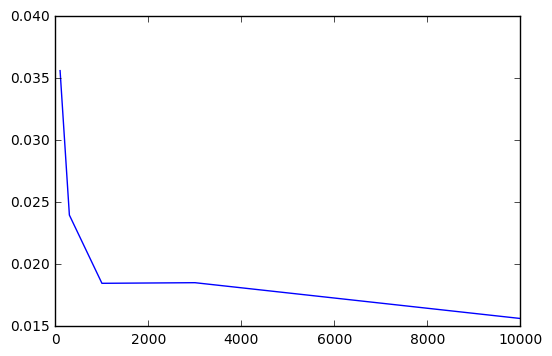

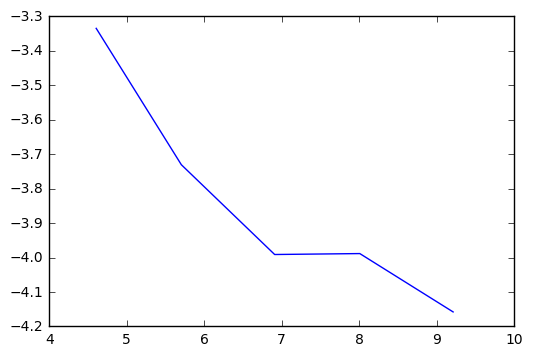

In [250]:
plt.plot([100, 300, 1000, 3000, 10000], variance)
plt.show()
#The first graph shows some sort of behavior that suggest we probably want to look at a power model

plt.plot([math.log(100), math.log(300), math.log(1000), math.log(3000), math.log(10000)], log_variance)
plt.show()


In [254]:
slope = (log_variance[4] - log_variance[0]) / (math.log(10000) - math.log(100))
print(slope)

-0.17877348072


The second graph above looks fine for linear regression. Although it is not ideal, the significance levels were computed with trial and error manually and thus are not completely optimal. If the significance levels were chosen perfectly, it is probable that we would get a graph very well suited to regression, allowing us to estimate the variance based on the number of objects. This gives us a good estimate of the tradeoff between runtime and accuracy as having more objects results in more runtime, but also greater accuracy.

As seen above, the slope is about -0.18, meaning that the variance decreases with $n^{0.18}$. As the number of objects increases, however, the value of the significance level gets more difficult to compute and it requires more precision to consistently produce a good result. As such, there is a very significant runtime increase as n increases, as the algorithm runs in O(n) time and we have to increase the number of test runs to compute a good value for the significance level.



As a side note, you can see below that using another distance metric, average euclidean distance, we also get a very similar looking graph. Hence, we can see that when we optimize on one distance metric, we tend to optimize for others as well. Furthermore, since average euclidean distance is the one that is most similar to the normal way of calculating variance for a parameter, this shows that this is probably a good estimate of the variance.

In [255]:
variance = np.zeros((5,))
for i, j in enumerate([100, 300, 1000, 3000, 10000]):
    significanceLevel = sigLevels[i]
    w, p, overallPDF = sample_to_pdf(sample, j)
    a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
    diff = euclidean_dist(c, overallPDF)
    variance[i] = np.sum(abs(diff))/125


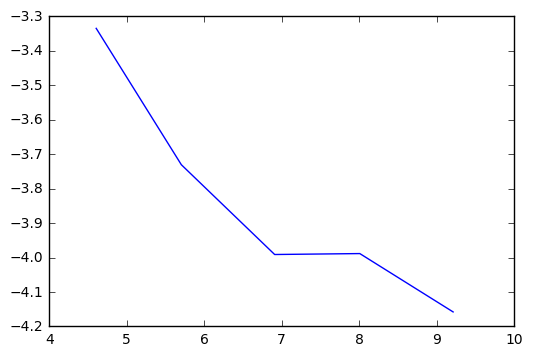

In [256]:
plt.plot([math.log(100), math.log(300), math.log(1000), math.log(3000), math.log(10000)], log_variance)
plt.show()